# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

##  Initialization

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import re

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, RadiusNeighborsClassifier
import math 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import arange
from sklearn.model_selection import GridSearchCV





from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

pd.set_option('display.max_rows', None, 'display.max_columns', None)

print("Setup Complete")

Setup Complete


## Load Data

In [2]:
try:
    df = pd.read_csv('insurance_us.csv')
    
except:
    df = pd.read_csv('/datasets/insurance_us.csv')

## Explore Data

In [3]:
df.head()

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


### Conclusion:
No missing values.

In [5]:
df.describe()

,Gender,Age,Salary,Family members,Insurance benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


### Conclusion:
Insurance benefits is imbalanced

## Rename variables

In [6]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

## Check type

In [7]:
df.head()

,gender,age,income,family_members,insurance_benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [8]:
df['age'] = df['age'].astype(int)

## Check for duplicates

In [9]:
df.duplicated().sum()

153

In [10]:
df.drop_duplicates(inplace=True, ignore_index=True)

## Final shape

In [11]:
df.shape

(4847, 5)

# EDA

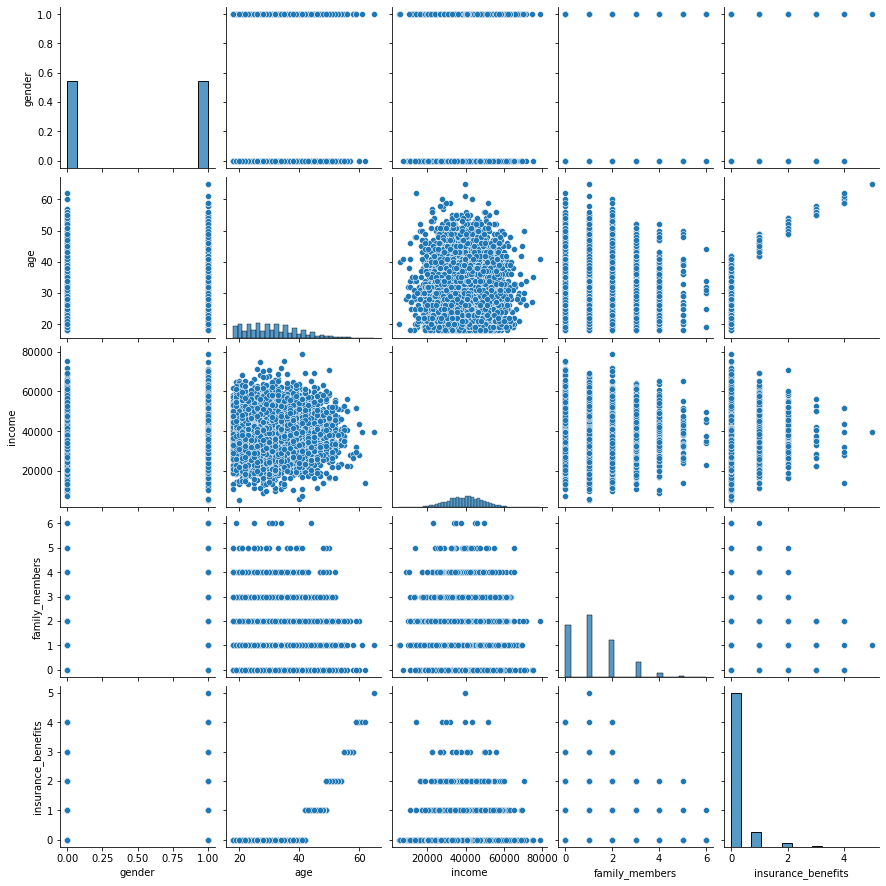

In [12]:
# creating copy of original data set
df_copy = df.copy()

# plotting pair plot for dataframe
sns.pairplot(df_copy)
plt.show()

## Conclusion:
Income and age are the only continuous variables.  Most family sizes are less than 3 members. Age is skewed towards younger generations.

# Task 1: Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

## The metrics Used

In [13]:
metrics = ['euclidean', 'manhattan']

## KNN Function
This function takes a dataframe, n objects, k neighbors, and a distance metric.  It fits NearestNeighbors model and extracts the distances and indices.  Then it returns a concatenated dataframe with indices and transposed distances

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

## Helper function

The helper function extracts the KNN results.

In [15]:
def check_knn_results(df, k, n, scaling='Scaled', metrics=[]):
    """
    Helper fucnction
    """
    for metric in metrics:
        print('{} results for {}'.format(scaling, metric))
        print('-'*50)
        print(get_knn(df, n, k, metric))
        print()

## Target Unscaled

In [16]:
# reduce the target to either received benefit 1, or not received benefit 0
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [17]:
df['insurance_benefits_received'].value_counts()/len(df) *100

0    88.384568
1    11.615432
Name: insurance_benefits_received, dtype: float64

In [18]:
df.sample(5)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
2145,0,18,43400.0,1,0,0
2770,1,27,28800.0,0,0,0
926,0,25,40400.0,3,0,0
4354,1,43,46300.0,1,1,1
3371,0,35,26100.0,2,0,0


## KNN Results Unscaled

In [19]:
# Check results for insured member 100. Without scaling
check_knn_results(df[feature_names], k=5, n=100, scaling='Unscaled', metrics=metrics)

Unscaled results for euclidean
--------------------------------------------------
      gender  age   income  family_members  distance
100        0   19  37300.0               1  0.000000
1803       0   20  37300.0               2  1.414214
2569       1   19  37300.0               0  1.414214
4147       1   19  37300.0               2  1.414214
1078       0   22  37300.0               3  3.605551

Unscaled results for manhattan
--------------------------------------------------
      gender  age   income  family_members  distance
100        0   19  37300.0               1       0.0
1803       0   20  37300.0               2       2.0
2569       1   19  37300.0               0       2.0
4147       1   19  37300.0               2       2.0
1078       0   22  37300.0               3       5.0



## Scaling the df

In [20]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [21]:
# reset the indices as the results with .loc and .iloc don't line up
df_scaled = df_scaled.reset_index(drop=True)

### Target Scaled

In [22]:
# reduce the target to either received benefit 1, or not received benefit 0
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0).astype(int)

In [23]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
782,1.0,0.400000,0.520253,0.166667,0,0
220,0.0,0.446154,0.426582,0.333333,0,0
4171,1.0,0.400000,0.467089,0.666667,0,0
1026,0.0,0.384615,0.244304,0.500000,0,0
3470,0.0,0.384615,0.627848,0.000000,0,0


### KNN with scaled data

In [24]:
# for insured member 100. With scaling
check_knn_results(df_scaled[feature_names], k=5, n=100, metrics=metrics)

Scaled results for euclidean
--------------------------------------------------
      gender       age    income  family_members  distance
100      0.0  0.292308  0.472152        0.166667  0.000000
4765     0.0  0.292308  0.477215        0.166667  0.005063
243      0.0  0.292308  0.467089        0.166667  0.005063
1309     0.0  0.292308  0.456962        0.166667  0.015190
806      0.0  0.307692  0.470886        0.166667  0.015437

Scaled results for manhattan
--------------------------------------------------
      gender       age    income  family_members  distance
100      0.0  0.292308  0.472152        0.166667  0.000000
4765     0.0  0.292308  0.477215        0.166667  0.005063
243      0.0  0.292308  0.467089        0.166667  0.005063
1309     0.0  0.292308  0.456962        0.166667  0.015190
806      0.0  0.307692  0.470886        0.166667  0.016650



**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Scaling does affect the KNN results. The scaled distances are much smaller (tighter) which results in totally different neighbors.  The scaled results all have the same gender, similar family_members numbers.  In contrast, the unscaled included both genders and clustered better on income

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The performance of both metrics is similar when scaled or unscaled

# Task 2: Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influence the evaluation metric, and whether scaling the data makes any difference. You can use a ready implementation of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

## Random Dummy Model

Defining the model

In [25]:
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

### Evalutation

Create a function that uses the F1 Score and outputs the confusion matrix properly labelled

In [26]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    # if you have an issue with the following line, restart the kernel and run the notebook again
    CM = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    print('Confusion Matrix:')
    print('TN = ', TN)
    print('FN = ', FN)
    print('TP = ', TP)
    print('FP = ', FP)
    

### Four Types of Probability

In [27]:
df['insurance_benefits_received'].sum() / len(df)

0.11615432226119249

This loop goes over the probabilities predicts their target and outputs the confusion matrix

In [28]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df), seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix:
TN =  0.8838456777388075
FN =  0.11615432226119249
TP =  0.0
FP =  0.0

The probability: 0.12
F1: 0.13
Confusion Matrix:
TN =  0.7850216628842583
FN =  0.10171239942232309
TP =  0.014441922838869404
FP =  0.09882401485454921

The probability: 0.50
F1: 0.19
Confusion Matrix:
TN =  0.4487311739220136
FN =  0.059211883639364554
TP =  0.056942438621827934
FP =  0.4351145038167939

The probability: 1.00
F1: 0.21
Confusion Matrix:
TN =  0.0
FN =  0.0
TP =  0.11615432226119249
FP =  0.8838456777388075



#### Conclusion:
The F1 are low; but the model performs better as the probability increases.  Yet, the performance of TN is higher as the probability is low and that of FP is higher as the probability is 1

## Build Two KNeighborsClassifier Models: One does not account for imablance and the other does

Here we already noted that the insurance_benefits variable was imbalanced.  So we will have 2 models to account for that.

### Split the Unscaled Data

In [29]:
train, valid = \
(
    train_test_split(df, stratify=df['insurance_benefits_received'], test_size=0.3, random_state=42)
)
features_train, target_train = train[feature_names], train['insurance_benefits_received']
features_valid, target_valid = valid[feature_names], valid['insurance_benefits_received']

features_train.shape, target_train.shape, features_valid.shape, target_valid.shape

((3392, 4), (3392,), (1455, 4), (1455,))

### Model

In [30]:
def build_model(features_train, target_train, target_valid):
    """
    Fit a model and make predictions
    """
    np.random.seed(42)
    model = KNeighborsClassifier(n_neighbors= k)
    model.fit(features_train, target_train)
    y_pred = model.predict(target_valid)
    return y_pred

#### Using Inbalanced Data 

In [31]:
for k in range(1, 11):
    y_pred = build_model(features_train, target_train, features_valid)
    print('For neighbor k={}'.format(k))
    eval_classifier(target_valid, y_pred)
    print()

For neighbor k=1
F1: 0.68
Confusion Matrix:
TN =  0.8680412371134021
FN =  0.04879725085910653
TP =  0.06735395189003436
FP =  0.015807560137457044

For neighbor k=2
F1: 0.40
Confusion Matrix:
TN =  0.8783505154639175
FN =  0.0859106529209622
TP =  0.030240549828178694
FP =  0.005498281786941581

For neighbor k=3
F1: 0.41
Confusion Matrix:
TN =  0.8735395189003436
FN =  0.0838487972508591
TP =  0.03230240549828179
FP =  0.010309278350515464

For neighbor k=4
F1: 0.21
Confusion Matrix:
TN =  0.8804123711340206
FN =  0.10240549828178694
TP =  0.013745704467353952
FP =  0.003436426116838488

For neighbor k=5
F1: 0.22
Confusion Matrix:
TN =  0.8790378006872852
FN =  0.10103092783505155
TP =  0.015120274914089347
FP =  0.004810996563573883

For neighbor k=6
F1: 0.02
Confusion Matrix:
TN =  0.8838487972508591
FN =  0.11477663230240549
TP =  0.0013745704467353953
FP =  0.0

For neighbor k=7
F1: 0.05
Confusion Matrix:
TN =  0.8810996563573883
FN =  0.1134020618556701
TP =  0.002749140893470790

### Split the already Scaled Data

In [32]:
train, valid = \
(
    train_test_split(df, test_size=0.3, random_state=42)
)

scaler = sklearn.preprocessing.MaxAbsScaler()

normalized_train = pd.DataFrame(
    scaler.fit_transform(train),
    columns = train.columns
)

normalized_valid = pd.DataFrame(
    scaler.fit_transform(valid),
    columns = train.columns
)


features_train_sc, target_train = normalized_train[feature_names], train['insurance_benefits_received']
features_valid_sc, target_valid = normalized_valid[feature_names], valid['insurance_benefits_received']

features_train_sc.shape, target_train.shape, features_valid_sc.shape, target_valid.shape

((3392, 4), (3392,), (1455, 4), (1455,))

#### Model 

#### Using Scaled Data and the KNN classifier

In [33]:
for k in range(1, 11):
    y_pred = build_model(features_train_sc, target_train, features_valid_sc)
    print('For neighbor k={}'.format(k))
    eval_classifier(target_valid, y_pred)
    print()

For neighbor k=1
F1: 0.84
Confusion Matrix:
TN =  0.8907216494845361
FN =  0.029553264604810996
TP =  0.07903780068728522
FP =  0.0006872852233676976

For neighbor k=2
F1: 0.78
Confusion Matrix:
TN =  0.8914089347079038
FN =  0.03917525773195876
TP =  0.06941580756013746
FP =  0.0

For neighbor k=3
F1: 0.84
Confusion Matrix:
TN =  0.8914089347079038
FN =  0.030240549828178694
TP =  0.07835051546391752
FP =  0.0

For neighbor k=4
F1: 0.79
Confusion Matrix:
TN =  0.8914089347079038
FN =  0.03711340206185567
TP =  0.07147766323024055
FP =  0.0

For neighbor k=5
F1: 0.82
Confusion Matrix:
TN =  0.8914089347079038
FN =  0.03367697594501718
TP =  0.07491408934707904
FP =  0.0

For neighbor k=6
F1: 0.80
Confusion Matrix:
TN =  0.8914089347079038
FN =  0.036426116838487975
TP =  0.07216494845360824
FP =  0.0

For neighbor k=7
F1: 0.82
Confusion Matrix:
TN =  0.8914089347079038
FN =  0.03367697594501718
TP =  0.07491408934707904
FP =  0.0

For neighbor k=8
F1: 0.78
Confusion Matrix:
TN =  0.891

## Conclusion:


The difference between the scaled and unscaled data KNN is that the F1 in the scaled version sores to 90\%

# Task 3: Regression (with Linear Regression)

## Build a Regression class

In [34]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([X.shape[0], 1]), X, axis=1)
        y_pred = np.dot(X2, self.weights)
        
        return y_pred

## Evaluate the Model

In [35]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

## Split the Unscaled Data

In [36]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

### Run the model

In [37]:
lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


## Split the Scaled Data

In [38]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

scaler = sklearn.preprocessing.MaxAbsScaler()

normalized_train = pd.DataFrame(
    scaler.fit_transform(X)
)



X_train_sc, X_test_sc, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

### Run the Model

In [39]:
lr_sc = MyLinearRegression()

lr_sc.fit(X_train_sc, y_train)
print(lr.weights)

y_test_pred = lr_sc.predict(X_test_sc)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


# Task 4: Obfuscating Data

In [40]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]
df_pn.head(5)

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0


In [41]:
X = df_pn.to_numpy()
X.shape

(4847, 4)

## Create a Random Matrix, P

In [42]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

## Check if P is Invertable

In [43]:
np.dot(P, np.linalg.inv(P))

array([[ 1.00000000e+00, -5.55111512e-17, -2.22044605e-16,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -1.11022302e-16,  1.00000000e+00,
         5.55111512e-17],
       [ 1.11022302e-16, -3.05311332e-16, -2.22044605e-16,
         1.00000000e+00]])

## Two arrays are element-wise equal within a tolerance

In [44]:
np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

True

## Transformed DF

In [45]:
pd.DataFrame(np.dot(X, P), columns=feature_names).head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


## Recreate the DF from the np.dot of P with the DF

In [46]:
pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))), columns=feature_names).head()

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,1.110223e-16,46.0,38000.0,1.000000e+00
2,0.000000e+00,29.0,21000.0,1.165734e-12
3,2.220446e-16,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,1.448841e-12


## Original data

In [47]:
pd.DataFrame(X, columns=feature_names).head()

,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


## Proof That Data Obfuscation Can Work with LR

source: https://stats.stackexchange.com/questions/490075/proving-that-the-hat-matrix-is-unchanged-even-when-the-predictors-are-multiplied

Given $\tilde{X} = XP$ for $P$ an invertible matrix, 

and 

Given that $(AB)^{-1}=B^{-1}A^{-1}$ and $(AB)^T=B^T A^T$,

and 

Given the multivariate regression equation:

$$\begin{align}
{\beta}(\tilde{X}) &= (\tilde{X}^T \tilde{X})^{-1}\tilde{X}^T y \\
&= (P^TX^TXP)^{-1}P^TX^T y \\
&= P^{-1}(X^TX)^{-1}P^{-T}P^TX^T y \\
&= P^{-1}(X^TX)^{-1}(PP^{-1})^TX^T y \\
&= P^{-1}(X^TX)^{-1}X^T y \\
&= P^{-1}\beta(X)
\end{align}$$

This shows that the only difference in the coefficients compared to the usual case is a multiple factor of $P^{-1}$.

However, looking solely at the residuals (which measure how far the model's predictions are from the true values), we see that the $P^{-1}$ factor must cancel out:

$$\begin{align}
y - X\beta(X) &= y - X\beta(X) \\
&= y - XPP^{-1}\beta(X) \\
 &= y - \tilde{X}\beta(\tilde{X}) \\
\end{align}
$$


In [48]:
pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))), columns=feature_names).head()

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,1.110223e-16,46.0,38000.0,1.000000e+00
2,0.000000e+00,29.0,21000.0,1.165734e-12
3,2.220446e-16,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,1.448841e-12


## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

### Generate the Matrix and Check for invertability

In [49]:
def generate_square_matrix(num_features, seed=42):
    """
    Generate a square matrix from a uniform distribution
    """
    rng = np.random.default_rng(seed=seed)
    return rng.random(size=(num_features, num_features))

In [50]:
P = generate_square_matrix(4, seed=1234)

In [51]:
def is_invertible(P):
    """
    Check if P is invertible or not
    """
    return np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

### Linear Regression with Obfuscated Data

In [52]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(np.dot(X, P), y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736802 -0.0861312  -0.09935778  0.1509952   0.06992258]
RMSE: 0.36
R2: 0.66


### Linear Regression with Scaled and Obfuscated Data

In [53]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(np.dot(X, P), y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736673  0.36150371 -1.23349037  3.3150945  -2.35958849]
RMSE: 0.36
R2: 0.66


#### Conclusion:
The results show that even after obfuscating the data, the RMSE and R2 score from the Linear Regression model are identical; this is independent of whether the data is scaled or not.

Final Remarks:

    - We used KNearestNeighbhors to find the a customer close to a given customer; the solution was improved with scaling and the Euclidean distance. 

    - We have also built models to help the marketing team predict whether a customer will likely receive insurance benefits. And, the resulting model with scaled data, performed very well compared to a dummy model. The resulting model produced had an F1 score of 92% on the validation set. 

    - We have also built a LinearRegression model on both scaled and unscaled data, to predict the number of insurance benefits a new customer would receive; the model produced a moderately high R2 score 66%. What we have observed is that scaling didn't impact the results. 

    - We obfuscated the data, and showed analytically that there is no difference between the obfuscated data and the original data.

    - We also proved this computationally, by building a LinearRegression model using the obfuscated data, and the resulting RMSE and R2 scores were identical to that obtained with modeling the original data.